Credits:  
[Autoformer](https://github.com/thuml/Autoformer)  
[FEDformer](https://github.com/MAZiqing/FEDformer)  

In [1]:
from types import SimpleNamespace
cfg = {
    # DATA
    'dataset_id':0,
    'step':20, # step input output 
    # 'target_len':20, # same for now

    # MODEL
    'emb_dim':8,
    'c_in':2, # dim of features in
    'n_heads':1,
    'batch_size':1,
    'seq_len':100,
}
cfg = SimpleNamespace(**cfg)

# PART WHERE DATA HAPPENS 

In [2]:
import os
import torch
from tqdm import tqdm
from scipy.io.wavfile import read
import matplotlib.pyplot as plt


In [3]:
base_paths = [
    '../data/music_data/VBB_DRUM_HITS/VBB_KICKS/',
    '../data/music_data/SOPHIE_sample_library/SOPHIE_one_shots/SOPHIE_drums/SOPHIE_kicks/all_kicks',
    '../data/music_data/Drums/Kicks',
    ]


Challenges:
1. Length of the signal
2. Scale or magnitude of the data 

In [4]:
'''
For each dataset, 
Store mean and std for z-score normalization
'''
mean_std_files = [
    'VBB_KICKS_zmean_zstd.yaml',
    'SOPHIE_zmean_zstd.yaml',
    'Drums_zmean_zstd.yaml'
    ]

z_scale = {}

for i, zs_file in enumerate(mean_std_files):
    z_mean = []
    z_std = []

    path = base_paths[i]
    
    if not os.path.exists(zs_file):
        filenames = os.listdir(path)
        filepaths = [os.path.join(path, fn) for fn in filenames]
        signals = []
        for fp in filepaths: 
            _, signal = read(fp)
            signal = torch.tensor(signal).flatten().float()
            signals += [signal]

        signals = torch.concat(signals, -1)
        z_mean = signals.mean().item()
        z_std = signals.std().item()

        # save values
        with open(zs_file, 'w') as f:
            f.write('z_mean:'+str(z_mean)+'\n')
            f.write('z_std:'+str(z_std))
            
        z_scale[zs_file] = [z_mean, z_std]
    
    # if files already exist
    else:
        with open(zs_file, 'r') as f:
            z_file = f.read()
        
        z_file = z_file.split('\n')
        z_mean = float(z_file[0].split(':')[1])
        z_std = float(z_file[1].split(':')[1])
        # print(z_mean, z_std)
        z_scale[zs_file] = [z_mean, z_std]


In [5]:
z_scale

{'VBB_KICKS_zmean_zstd.yaml': [-561862.3125, 459715136.0],
 'SOPHIE_zmean_zstd.yaml': [30967.67578125, 538729664.0],
 'Drums_zmean_zstd.yaml': [3.824542284011841, 11310.7451171875]}

In [6]:
class Dataset:
    def __init__(self, path, cfg, z_scale):
        filepaths = self._get_filepaths(path)
        self.samples = self._get_samples(filepaths, cfg, z_scale)
        self._len = len(self.samples)

    def __getitem__(self, idx):
        source = self.samples[idx]
        target = source
        return source, target

    def __len__(self):
        return self._len

    def _get_filepaths(self, path):
        filenames = os.listdir(path)

        filepaths = [os.path.join(path, fn) for fn in filenames]
        return filepaths 

    def _get_samples(self, filepaths, cfg, z_scale):
        samples = []
        z_mean = z_scale[0]
        z_std = z_scale[1]

        for path in filepaths:
            _, signal = read(path)
            signal = (torch.tensor(signal) - z_mean) / z_std
            position = torch.arange(signal[:,0].size()[0]).unsqueeze(-1)
            signal = torch.concat((signal, position), -1)

            # Separate signal to samples
            for i in range(0, signal.shape[0]-cfg.step, cfg.step):
                # print(signal.shape[0],i,i+cfg.step)
                samples += [signal[i:i+cfg.step]]
        return samples

In [7]:
ds_path = base_paths[cfg.dataset_id]

key = list(z_scale.keys())[cfg.dataset_id]
ds_z_scale = z_scale[key]

train_ds = Dataset(ds_path, cfg, ds_z_scale)

/tmp/ipykernel_150169/1586169513.py:27: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, signal = read(path)


In [8]:
a,b = train_ds[0]
a.shape, b.shape, len(train_ds)

(torch.Size([20, 3]), torch.Size([20, 3]), 192141)

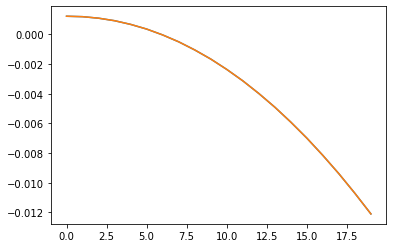

In [9]:
key = list(z_scale.keys())[cfg.dataset_id]

for i in range(1):
    zmean = z_scale[key][0]
    zstd = z_scale[key][1]
    # print(ds[i].shape)
    plt.figure()
    # plt.plot(ds[i])
    # plt.plot((ds[i][0][:,:2] - zmean) / zstd)
    plt.plot(train_ds[i][0][:,:2])
    plt.show()

In [10]:
from torch.utils.data import DataLoader 
train_dl = DataLoader(train_ds, batch_size=64, drop_last=True)

# PART WHERE MODEL HAPPENS 
kinda

In [11]:
source, target = train_ds[1000]

In [12]:
source

tensor([[-2.6886e-01, -2.6886e-01,  2.0000e+04],
        [-2.6179e-01, -2.6179e-01,  2.0001e+04],
        [-2.5489e-01, -2.5489e-01,  2.0002e+04],
        [-2.4792e-01, -2.4792e-01,  2.0003e+04],
        [-2.4093e-01, -2.4093e-01,  2.0004e+04],
        [-2.3385e-01, -2.3385e-01,  2.0005e+04],
        [-2.2674e-01, -2.2674e-01,  2.0006e+04],
        [-2.1979e-01, -2.1979e-01,  2.0007e+04],
        [-2.1265e-01, -2.1265e-01,  2.0008e+04],
        [-2.0559e-01, -2.0559e-01,  2.0009e+04],
        [-1.9839e-01, -1.9839e-01,  2.0010e+04],
        [-1.9131e-01, -1.9131e-01,  2.0011e+04],
        [-1.8438e-01, -1.8438e-01,  2.0012e+04],
        [-1.7700e-01, -1.7700e-01,  2.0013e+04],
        [-1.6990e-01, -1.6990e-01,  2.0014e+04],
        [-1.6265e-01, -1.6265e-01,  2.0015e+04],
        [-1.5553e-01, -1.5553e-01,  2.0016e+04],
        [-1.4835e-01, -1.4835e-01,  2.0017e+04],
        [-1.4107e-01, -1.4107e-01,  2.0018e+04],
        [-1.3394e-01, -1.3394e-01,  2.0019e+04]])

In [13]:
position = source[:,2]
position

tensor([20000., 20001., 20002., 20003., 20004., 20005., 20006., 20007., 20008.,
        20009., 20010., 20011., 20012., 20013., 20014., 20015., 20016., 20017.,
        20018., 20019.])

In [49]:
'''
this guy help me to figure out what is going on with positional encodings
https://jamesmccaffrey.wordpress.com/2022/02/09/positional-encoding-for-pytorch-transformer-architecture-models/
'''

class SimplePositionalEncoding:
    def __init__(self, cfg):
        self.pos_emb_dim = cfg.emb_dim
        self.factor = -torch.log(torch.tensor(10000.0)) / self.pos_emb_dim

    def __call__(self, x):
        pos_embedings = []
        print('x',x.shape)
        for i in range(self.pos_emb_dim):
            div_term = torch.exp(i * self.factor)
            pe = torch.cos(x * div_term).unsqueeze(-1)
            print(pe.shape)
            pos_embedings += [pe]
            
        pos_embedings = torch.concat(pos_embedings, -1)

        return pos_embedings

In [51]:

pos_encoding = SimplePositionalEncoding(cfg)
# pos_embedings = pos_encoding(position)

pos_encoding(source[:,:,2])

x torch.Size([64, 20])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])
torch.Size([64, 20, 1])


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.5403,  0.9504,  0.9950,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4161,  0.8066,  0.9801,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.2752,  0.6159, -0.1288,  ...,  0.9986,  0.9999,  1.0000],
         [ 0.6603,  0.8303, -0.2272,  ...,  0.9984,  0.9998,  1.0000],
         [ 0.9887,  0.9625, -0.3233,  ...,  0.9982,  0.9998,  1.0000]],

        [[ 0.4081,  0.9991, -0.4161,  ...,  0.9980,  0.9998,  1.0000],
         [-0.5477,  0.9367, -0.5048,  ...,  0.9978,  0.9998,  1.0000],
         [-1.0000,  0.7814, -0.5885,  ...,  0.9976,  0.9998,  1.0000],
         ...,
         [ 0.7654,  0.6479, -0.8481,  ...,  0.9932,  0.9993,  0.9999],
         [ 0.9551,  0.8527, -0.7910,  ...,  0.9928,  0.9993,  0.9999],
         [ 0.2666,  0.9729, -0.7259,  ...,  0.9924,  0.9992,  0.9999]],

        [[-0.6669,  0.9966, -0.6536,  ...,  0.9920,  0.9992,  0.9999],
         [-0.9873,  0.9215, -0.5748,  ...,  0

torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])


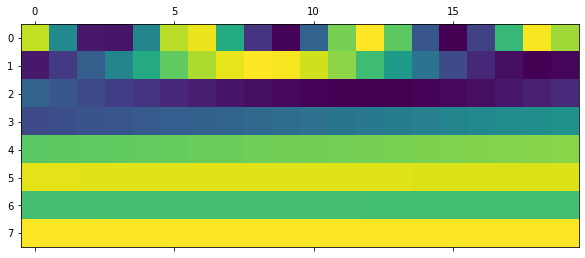

In [35]:
plt.matshow(pos_embedings)

In [36]:
import torch
import torch.nn as nn
from autocorrelation import AutoCorrelationLayer, AutoCorrelation, TokenEmbedding

class SmallerModel(nn.Module):
    '''
    Like autoformer but smaller
    '''
    def __init__(self, cfg):
        super().__init__()

        self.pos_encoder = SimplePositionalEncoding(cfg)
        self.src_encoder = TokenEmbedding(cfg.c_in, cfg.emb_dim)

        auto_correletion = AutoCorrelation(
            factor=1, # used for top_k prediction thing
            attention_dropout=0.05,
            output_attention=True,

            scale=None, # does nothing (never used)
            mask_flag=True, # does nothing (never used)
        )

        emb_dim = 2
        self.f1 = nn.Linear(cfg.c_in, emb_dim)

        self.autocorr_layer = AutoCorrelationLayer(
            correlation=auto_correletion,
            d_model=emb_dim,
            n_heads=cfg.n_heads,
            d_keys=None) # Why we not use it? who knows
    
        self.f2 = nn.Linear(emb_dim, cfg.c_in)

    def forward(self, source, target_position, attn_mask=None):
        data = source[:,:,:2]
        position = source[:,:,2].unsqueeze(-1)
        print(position.shape, data.shape)

        # HERE WE USE POWER OF ENCODER !!!
        # encoding position (batch_size, seq_len, )
        pos_enc = self.pos_encoder(position)
        src_enc = self.src_encoder(data)

        print(pos_enc.shape, src_enc.shape)

        1/0

        pos_dec = self.pos_encoder(target_position)

        x = self.f1(x)

        x,corr = self.autocorr_layer(x,x,x, attn_mask)

        x = self.f2(x)

        return x, corr

model = SmallerModel(cfg)
batch = next(iter(train_dl))
source, target = batch
target_position = target[:,2]

print(source[:,:,:].shape)
out = model(source, target_position)

torch.Size([64, 20, 3])
torch.Size([64, 20, 1]) torch.Size([64, 20, 2])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([1, 20])
torch.Size([8, 20]) torch.Size([64, 20, 8])


ZeroDivisionError: division by zero

torch.Size([64, 20, 2])


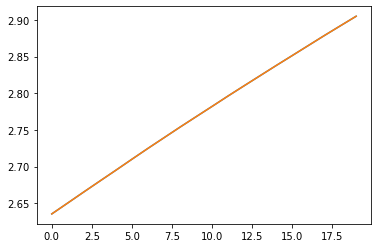

In [22]:
data = source[:,:,:2]
print(data.shape)
plt.plot(data[-1])

In [224]:
criterion_mse =  nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), 1e-3)

losses = []
for epoch in tqdm(range(100)):

    for batch in train_dl:
        source, target = batch
        out,_ = model(source)
        1/0

        loss = criterion_mse(out, target)
        loss.backward()
        opt.step()

        losses += [loss.item()]
        break
    break
    print(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1280x3 and 2x2)

In [8]:


my_dummy_data = torch.rand(cfg.batch_size, cfg.seq_len, cfg.d_model)
my_dummy_data.shape

torch.Size([1, 100, 2])

In [47]:
data = ds[0][:cfg.seq_len].unsqueeze(0).float() / 10000
data.shape

torch.Size([1, 100, 2])

100%|██████████| 100/100 [00:00<00:00, 202.36it/s]


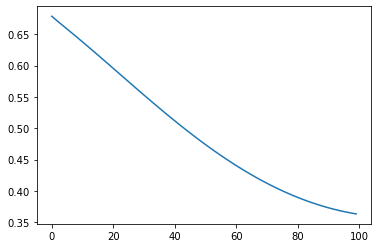

In [50]:
plt.plot(losses)
# plt.yscale('log')

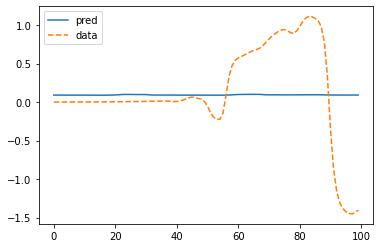

In [51]:
plt.figure()
plt.plot(out.detach()[0][:,0], label='pred')
plt.plot(data[0,:,0], '--', label='data')
plt.legend()
plt.show()
